**Step 1: data pre-process steps and initial feature extraction**<br/>

**Step 2: Data insights and visualization including drop outliers**<br/>
* Basic stats, dividends per year, abnormal return hist given div direction<br/>
* outliers range?


**Step 3: Base line model**<br/>
* Should we split train/test in the research linear regression? same for the regular one
* Which columns should I drop?


**Step 4: Analysis of error + conclusions (years 2008-2009)**


**Step 5: Sensitivity analysis (size of window)**


**Step 6: Run new model (Regression) (naive + feature handler)**


**Step 7: Run different Regression models and compare**


**Step 8: Discrete Models**


**Step 9: Cross Validation, results and conclusions**


In [304]:
import imp
imp.reload(main)
imp.reload(regression_models)
imp.reload(feature_handler)

<module 'feature_handler.feature_handler' from 'C:\\Users\\Owner\\GIT\\DS2\\DataSci\\feature_handler\\feature_handler.py'>

In [305]:
from aggregate import aggregate
from aggregate import capm_params
from feature_handler import feature_handler
from run_model import regression_models
from visualize import visualize
import pandas as pd
import numpy as np
import main
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

# Data Science Workshop - Project notebook

**TODO: introduction**

### Step 0: Notebook Intialization
seed: 
>We ran the notebook using seed = 10

run_speed:
>3 - fastest (immediate)<br/>
    2 - avrage<br/>
    1 - slowest

In [306]:
seed = 10
random.seed(seed)
np.random.seed(seed)
run_speed = 3

### Step 1: data pre-process steps and initial feature extraction

In [310]:
df = pd.read_csv("aggregated_data.csv")
display(df.head(1))

company_name symbol                       industry  \
0  American Airlines Group, Inc.    AAL  Air Freight/Delivery Services   

           sector dividend_date dividend_amount      alpha      beta  \
0  Transportation    2019-10-22           $0.10 -33.847291  0.020567   

   price_t-5    vol_t-5  ...  year  month  quarter  MV Debt Ratio  \
0      27.93  6709600.0  ...  2019     10        4          0.229   

   BV Debt Ratio  Effective Tax Rate  Std Deviation In Prices  EBITDA/Value  \
0          0.558               0.084                    0.385           0.1   

   Fixed Assets/BV of Capital  Capital Spending/BV of Capital  
0                       0.319                           0.047  

[1 rows x 62 columns]

We will predesnt our data and features.<br/>
Each sample is a specific dividend declaration of some company.
For each sample we have:
* **company_name , symbol**
* **sector , industry** - sector is more general, while industry is more specific
* **dividend_date** - the declaration date of the dividend.
* **dividend_amount** - the amount (in USD) of the dividend
* **alpha, beta** - the coefficients of the CAPM model (more on that in the PDF documentation)<br/>


* **price_t-i ,price_t+i** - the actual stock price i days before/after the declaration (for $i\in\{0,...,5\}$)
* **expected_t-i ,expected_t+i** - the expected stock price (using CAPM model) i days before/after the declaration: $expected\_i = \alpha + \beta*sp\_i$ (for $i\in\{0,...,5\}$)
* **vol_t-i ,vol_t+i** - the trade volume of the stock, i days before/after the declaration (for $i\in\{0,...,5\}$)
* **sp_price_t-i ,sp_price_t+i** - the S&P500 price i days before/after the declaration (for $i\in\{0,...,5\}$)
* **sp_vol_t-i ,sp_vol_t+i** - the trade volume of S&P500, i days before/after the declaration (for $i\in\{0,...,5\}$)


* **MV Debt Ratio,BV Debt Ratio, Effective Tax Rate, Std Deviation In Prices, EBITDA/Value, Fixed Assets/BV of Capital, Capital Spending/BV of Capital** - all those are economics relations, more on that on the PDF documentation.<br/>



In [311]:
_ = main.print_basic_stats(df)

Data Stats:
	#Samples: 39913
	#Features: 62
	#Samples with NaNs: 86


Next we would like to do very intial data pre-processing:
1. Drop NaNs - We don't have alot of samples with NaNs, hence droping them seems like the right to handle them.
2. Take care of data types - basic conversion from string to float.
3. Add features:
>**dividend change** - $\frac{dividend\_amount}{last\_dividend\_amount}$ - this is the relative change in the dividend amount compare to the previous declaration from this company. If this is the first declaration we set it to 1.<br/> **dividend change direction** - the direction of change (1: increase, -1: decrease, 0: unchanged), if this is the first declaration we have we treated it as increase (1).<br/>
4. Calculate additional features:
>$ar\_i = expected\_i - price\_i$<br/>
$aar\_i = \frac{\sum_{k=-i}^i{ar_k}}{2i+1}$<br/>

As of now, we will think of "aar_5" as our response. <br/>
("aar_i%" will be discussed later)

In [312]:
main.step1_wrapper(df, run_speed = run_speed)
_ = main.print_basic_stats(df)

Dropped 86 rows with NaN values
Created div_direction and div_change
Created expected_t, ar_t, aar_t, aar_t%

Data Stats:
	#Samples: 39746
	#Features: 98
	#Samples with NaNs: 0


We have almost 40K samples, 98 featuers, and non missing values.<br/>
At this point we want to point out that not all the features are valid for use in prediction of "aar_5", some of them already contains information about it - for example "aar_4". We will get back to this point later.

### Step 2: Data insights and visualization including drop outliers

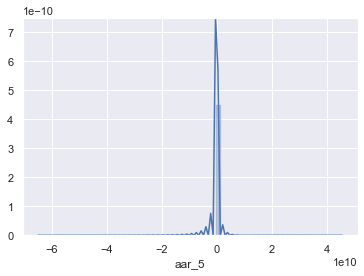

In [273]:
#show dist of aar_5
_ = sns.distplot(df['aar_5'])

In [270]:
df_aar_5_no_outliers = main.remove_outliers(df, range_min = -50 , range_max = 50)

Removed 57 outliers


One more thing we had in mind is to normalize the abnormal return, that's why we created "aar_i%",<br/>
which is the same as "aar_i" but divided by the mean of the expected values:<br/>
$aar\_i\% = \frac{aar\_i}{(\sum_{k=-i}^{i}{expected_k})/(2i+1)}$<br/>
The logic behind this is that we want to 'scale' the mistake - it's make more sense to look at the abnormal return as a fraction of the expected price than as an absolute value.<br/>
We will predict arr_5% instead of aar_5

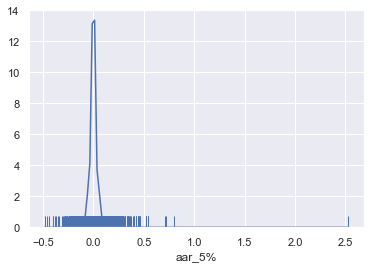

In [260]:
#show dist of aar_5%
_ = sns.distplot(df['aar_5%'], hist = False, rug = True)

In [261]:
df_aar_5_precent_no_outliers = main.remove_outliers(df, range_min = -1, range_max = 1, y_col = 'aar_5%')


Removed 1 outliers


**Train/Test Split**<br/>
Before we proceed we will split our data into train and test sets.

In [262]:
df_aar_5_precent_train, df_aar_5_precent_test = main.train_test_split(df_aar_5_precent_no_outliers)

### Step 3: Base line model
This step include to parts:
1. Research replication
2. Run simple linear regression to use as a baseline

Recall we are trying to predict "arr_5", hence we will not use any related features.<br/>
While we are using linear regression we won't split the data into train and test, the reason we can justify it is that linear regression is relatively low-variance model, so the chance to overfit is very small.<br/>
In addition we still have some categorical features, as of now we will just drop them. This leaves us with:

In [313]:
_ = main.generate_bl_model_data(df, print_ = True, y_col = 'aar_5%')

Baseline model features: {'quarter', 'Effective Tax Rate', 'div_direction', 'EBITDA/Value', 'alpha', 'div_change', 'year', 'month', 'Capital Spending/BV of Capital', 'beta', 'MV Debt Ratio', 'Std Deviation In Prices', 'Fixed Assets/BV of Capital', 'BV Debt Ratio', 'div_amount_num'}


**Research replication**<br/>
Previous research, looked only at the samples where $div\_change \neq 0$, using linear regression they recieved R^2 of abot 7%, we will try to replicate it.

In [314]:
#Regression model - Research
research_baseline_model_data = main.generate_bl_model_data(df_aar_5_no_outliers, print_ = False, y_col = 'aar_5')
research_baseline_model_data = research_baseline_model_data[research_baseline_model_data['div_direction'] != 0]
_ = regression_models.run_linear_reg(research_baseline_model_data) 

R^2: 0.012338446092088784


TODO: discuss the reuslt

**Linear regression as baseline**<br/>
Use simple linear regression on our data:

In [316]:
bl_model_data = main.generate_bl_model_data(df_aar_5_precent_train, print_ = False, y_col = 'aar_5%')
bl_model = regression_models.run_linear_reg(bl_model_data, y_col = 'aar_5%')

R^2: 0.004133964073029239


TODO: Discuss the results

### Step 4: Analysis of error for the base line model + conclusions (years 2008-2009)
TODO: visualize and discuss

In [264]:
baseline_model_data_no20089 = main.remove_2008_2009(baseline_model_data)
_ = regression_models.run_linear_reg(baseline_model_data_no20089, y_col = "aar_5%")

Removed 3219 samples from years 2008 - 2009
R^2: 0.0034791873471685664


### Step 5: Sensitivity analysis (size of window)

As a result of the disapointing results, we will try to revisit our assumptions, in particular the "window" size we chose.<br/>
TODO: explain why windows size of -1,5

In [265]:
_ =visualize.window_analysis(feature_handler.create_asymmetric_window(df, -1, 5), 'asy')

      aar_0%  aar_1%  aar_2%  aar_3%  aar_4%  aar_5%  aar_asy-1_5%
down   -0.38   -0.40   -0.39   -0.38   -0.37   -0.37         -0.42
flat   -0.04   -0.04   -0.03   -0.02   -0.02   -0.02          0.01
up      0.21    0.26    0.29    0.31    0.33    0.34          0.47


One thing to notice here is that in the asymmetric window we get the most 'extreme' result, so we will choose the asymetric windows

In [266]:
start, end = -1 ,5
y_col = "aar_asy{}_{}%".format(str(start), str(end))
baseline_data_ws = main.generate_bl_model_data(df_aar_5_precent_no_outliers,\
                                                             window_size=(start, end),\
                                                             drop_08_09 = True,
                                                             print_ = 0)
_ = regression_models.run_linear_reg(baseline_data_ws, y_col = y_col)

R^2: 0.005622530757547817


In [195]:
#REMOVE?
for ws, y_col in [(1,'aar_1%'), (2, 'aar_2%'), ((-1,5) ,"aar_asy{}_{}%".format(*(-1,5)))]:
    baseline_data_ws1 = main.generate_bl_model_data(df,
                                                 window_size=ws,
                                                 y_col=y_col,
                                                 delta_precentage = True,
                                                 drop_08_09 = True,
                                                 print_ = 0)
    print("Window: "+str(ws), end = ', ')
    _ = regression_models.run_linear_reg(baseline_data_ws1, y_col = y_col, print_summary= 0)

Window: 1, R^2: 0.5115021070105381
Window: 2, R^2: 0.47956282982090326
Window: (-1, 5), R^2: 0.3884256822257537


TODO: discuss the results

### Step 6: Run new model (Regression) (naive + feature handler)

We will consider two new features, since we normalized our response, it's make sense to also normalize in the same way the new features that were added from the window size change.<br/>
$delta\_\%\_{t-5}=\frac{price_{t-5} - expected_{t-5}}{expected_{t-5}}$

$delta\_\%\_{t-4}=\frac{price_{t-4} - expected_{t-4}}{expected_{t-4}}$

In [200]:
ws, y_col = ((-1,5) ,"aar_asy{}_{}%".format(*ws))
baseline_data_ws = main.generate_bl_model_data(df,
                                             window_size=ws,
                                             y_col=y_col,
                                             delta_precentage = True,
                                             drop_08_09 = True,
                                             print_ = 0)
_ = regression_models.run_linear_reg(baseline_data_ws, y_col = y_col)

R^2: 0.3884256822257537


Seems like that gave us a big improvment.<br/>
That's raise some thoughts about the importance of the other features, using Recursive Feature Elimination gets $delta\_\%\_{t-4}$ as the highest ranking feature

In [201]:
regression_models.rfe(baseline_data_ws, y_col, n_features_to_select=1)

{'delta_%_t-4'}

Running linear regression using only 'delta_%_t-4' support this decision

In [202]:
_ = regression_models.run_linear_reg(baseline_data_ws1[['delta_%_t-4', y_col]], y_col = y_col, print_summary= 0)

R^2: 0.38595617677789495


We can see that the R squared is very close to the linear regression that used all the features.

### Step 7: Run different Regression models and compare
Now we want to leave the linear regression model, and use more complex models.<br/>
First we will split the data into train and test.

In [203]:
ws = (-1,5) 
y_col = "aar_asy{}_{}%".format(*ws)
pred_data = main.generate_bl_model_data(df,
                                         window_size=ws,
                                         y_col=y_col,
                                         delta_precentage = True,
                                         drop_08_09 = True,
                                         print_ = 0)
X_train, X_test, y_train, y_test = main.split_test_train(pred_data, y_col = y_col, test_size = 0.33)

Next we will introduce new baseline models:<br/>
* The First one will be a simple linear regression, using only the variable 'delta_%_t-4'
* The second one will be a constant model which always predict the mean value of y_train.<br/>

In addition we will now look at the mean squared error instead of the R squared we looked at before. We want to compare models that aren't linear regression. In praticular we will examine the mse*(10^4) because the scale if very small.

In [204]:
bl_model_lg, bl_model_const = regression_models.step7_bl_models(X_train, X_test, y_train, y_test)

Linear Regression model mse*e+4: 15.39714828401666
Constant model mse*e+4: 25.10803161952498


We examined few models, such as: MLP Regressor, XGBoost and Random Forest.<br/>
We didn't get better results than our baselines, but we could see that the models that got good results 'converged' to one of the baseline models.<br/>
We decided to first use our linear regression baseline model and then predict it's error:

In [205]:
y_delta_train = y_train - bl_model_lg.predict(X_train[['delta_%_t-4']])
y_delta_test = y_test - bl_model_lg.predict(X_test[['delta_%_t-4']])

After considering few models, Random Forest gave us the best results:

In [216]:
rf_model = main.fit_rf(X_train, y_delta_train, n_estimators=10, run_speed =1)
display(rf_model)
predictions = rf_model.predict(X_test) + bl_model_lg.predict(X_test[['delta_%_t-4']])
print("Total mse using lr+rf: {}".format(regression_models.mse(predictions, y_test)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Total mse using lr+rf: 16.180327460251682


### Step 8: Discrete Models

### Step 9: Cross Validation, results and conclusions